## Step 1 — Install & Import

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

print(f'TensorFlow version: {tf.__version__}')
print('All imports successful')

TensorFlow version: 2.19.0
All imports successful


## Step 2 — Synthetic Data Generator

**Biological logic encoded:**
- Sequences of length 50 (simulating a gene window)
- Known functional motifs: `ATGCG`, `GCATG`, `TTAGG` (active sites / promoter-like)
- Mutation **inside** a motif → **High Impact** (label=1)
- Mutation **outside** motifs → **Low Impact** (label=0)
- Added noise: ~10% label flip to simulate biological ambiguity

In [2]:
# ─────────────────────────────────────────────
# Configuration
# ─────────────────────────────────────────────
SEQ_LEN = 50
NUM_SAMPLES = 5000
BASES = ['A', 'T', 'C', 'G']
FUNCTIONAL_MOTIFS = ['ATGCG', 'GCATG', 'TTAGG']  # High-impact regions
NOISE_RATE = 0.10  # Biological ambiguity

# ─────────────────────────────────────────────
# One-hot encoder
# ─────────────────────────────────────────────
BASE_TO_IDX = {'A': 0, 'T': 1, 'C': 2, 'G': 3}

def one_hot_encode(sequence):
    """Encode DNA sequence to (SEQ_LEN, 4) matrix."""
    encoded = np.zeros((len(sequence), 4), dtype=np.float32)
    for i, base in enumerate(sequence):
        encoded[i, BASE_TO_IDX[base]] = 1.0
    return encoded

# ─────────────────────────────────────────────
# Sequence generator
# ─────────────────────────────────────────────
def generate_sample():
    """Generate one (sequence, mutation_position, new_base, label) sample."""
    seq = list(np.random.choice(BASES, SEQ_LEN))

    # Randomly embed 0-2 motifs
    motif_positions = set()
    for motif in FUNCTIONAL_MOTIFS:
        if random.random() > 0.4:
            pos = random.randint(0, SEQ_LEN - len(motif))
            seq[pos:pos+len(motif)] = list(motif)
            for p in range(pos, pos+len(motif)):
                motif_positions.add(p)

    # Pick a mutation position
    mut_pos = random.randint(0, SEQ_LEN - 1)
    original_base = seq[mut_pos]
    new_base = random.choice([b for b in BASES if b != original_base])

    # Apply mutation
    mutated_seq = seq.copy()
    mutated_seq[mut_pos] = new_base

    # Label: high impact if mutation hits a motif
    label = 1 if mut_pos in motif_positions else 0

    # Add biological noise
    if random.random() < NOISE_RATE:
        label = 1 - label

    return ''.join(mutated_seq), mut_pos, new_base, label

# ─────────────────────────────────────────────
# Generate dataset
# ─────────────────────────────────────────────
print(f'Generating {NUM_SAMPLES} mutation samples...')

X_seq, X_pos, X_base, y = [], [], [], []

for _ in range(NUM_SAMPLES):
    seq, pos, base, label = generate_sample()
    X_seq.append(one_hot_encode(seq))          # (50, 4)
    X_pos.append(pos / SEQ_LEN)                # Normalized position scalar
    X_base.append(BASE_TO_IDX[base] / 3.0)     # Normalized base identity
    y.append(label)

X_seq = np.array(X_seq)   # (N, 50, 4)
X_pos = np.array(X_pos).reshape(-1, 1)   # (N, 1)
X_base = np.array(X_base).reshape(-1, 1) # (N, 1)
y = np.array(y)

print(f'X_seq shape:  {X_seq.shape}')
print(f'X_pos shape:  {X_pos.shape}')
print(f'y shape:      {y.shape}')
print(f'Class balance — High Impact: {y.sum()} | Low Impact: {(1-y).sum()}')

Generating 5000 mutation samples...
X_seq shape:  (5000, 50, 4)
X_pos shape:  (5000, 1)
y shape:      (5000,)
Class balance — High Impact: 1228 | Low Impact: 3772


## Step 3 — Train/Val/Test Split

In [3]:
# Split indices
idx = np.arange(NUM_SAMPLES)
idx_train, idx_temp = train_test_split(idx, test_size=0.2, random_state=42, stratify=y)
idx_val, idx_test   = train_test_split(idx_temp, test_size=0.5, random_state=42, stratify=y[idx_temp])

def split(arr, idx): return arr[idx]

X_seq_train, X_seq_val, X_seq_test   = split(X_seq,  idx_train), split(X_seq,  idx_val), split(X_seq,  idx_test)
X_pos_train, X_pos_val, X_pos_test   = split(X_pos,  idx_train), split(X_pos,  idx_val), split(X_pos,  idx_test)
X_base_train, X_base_val, X_base_test = split(X_base, idx_train), split(X_base, idx_val), split(X_base, idx_test)
y_train, y_val, y_test               = split(y, idx_train), split(y, idx_val), split(y, idx_test)

print(f'Train: {len(y_train)} | Val: {len(y_val)} | Test: {len(y_test)}')

Train: 4000 | Val: 500 | Test: 500


## Step 4 — Build the HelixMind Model

**Architecture:**
```
DNA Sequence Input (50, 4)
    └─ Conv1D(32, kernel=3) + BatchNorm + ReLU
    └─ Conv1D(64, kernel=3) + BatchNorm + ReLU
    └─ GlobalMaxPooling1D
    └─ Dense(32)
         ↕ Concat
Mutation Position (1) ──┐
New Base Identity  (1) ─┘
    └─ Dense(16) → Dense(1, sigmoid)
```

In [4]:
def build_helixmind_model(seq_len=50, dropout_rate=0.3):
    # ── Sequence branch (1D CNN)
    seq_input = keras.Input(shape=(seq_len, 4), name='sequence')

    x = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(seq_input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalMaxPooling1D()(x)  # (batch, 64)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    # ── Mutation metadata branch
    pos_input  = keras.Input(shape=(1,), name='mutation_position')
    base_input = keras.Input(shape=(1,), name='new_base')
    meta = layers.Concatenate()([pos_input, base_input])
    meta = layers.Dense(8, activation='relu')(meta)

    # ── Merge
    merged = layers.Concatenate()([x, meta])
    merged = layers.Dense(16, activation='relu')(merged)
    merged = layers.Dropout(dropout_rate)(merged)
    output = layers.Dense(1, activation='sigmoid', name='impact_probability')(merged)

    model = keras.Model(
        inputs=[seq_input, pos_input, base_input],
        outputs=output,
        name='HelixMind_v0'
    )
    return model

model = build_helixmind_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

model.summary()

Model: "HelixMind_v0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 50, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 50, 32)    │        416 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 32)    │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 50, 64)    │      6,208 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mutation_position   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ new_base            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2)         │          0 │ mutation_positio… │
│ (Concatenate)       │                   │            │ new_base[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │         24 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 40)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        656 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ impact_probability  │ (None, 1)         │         17 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,785 (38.22 KB)

 Trainable params: 9,593 (37.47 KB)

 Non-trainable params: 192 (768.00 B)

## Step 5 — Train

In [5]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    x=[X_seq_train, X_pos_train, X_base_train],
    y=y_train,
    validation_data=([X_seq_val, X_pos_val, X_base_val], y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print('\n Training complete')

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.7078 - auc: 0.5023 - loss: 0.7226 - val_accuracy: 0.7540 - val_auc: 0.4819 - val_loss: 0.6716 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7375 - auc: 0.5230 - loss: 0.5867 - val_accuracy: 0.7540 - val_auc: 0.4856 - val_loss: 0.6614 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7386 - auc: 0.5023 - loss: 0.5878 - val_accuracy: 0.7540 - val_auc: 0.5068 - val_loss: 0.6398 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7451 - auc: 0.5222 - loss: 0.5766 - val_accuracy: 0.7540 - val_auc: 0.5397 - val_loss: 0.6232 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7457 - auc: 0.5397 - loss: 0.5736 - val_accuracy: 0.7540 - val_auc: 0.5348 - val_loss: 0.6035 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7451 - auc: 0.5455 - los

## Step 6 — Evaluation & Visualizations

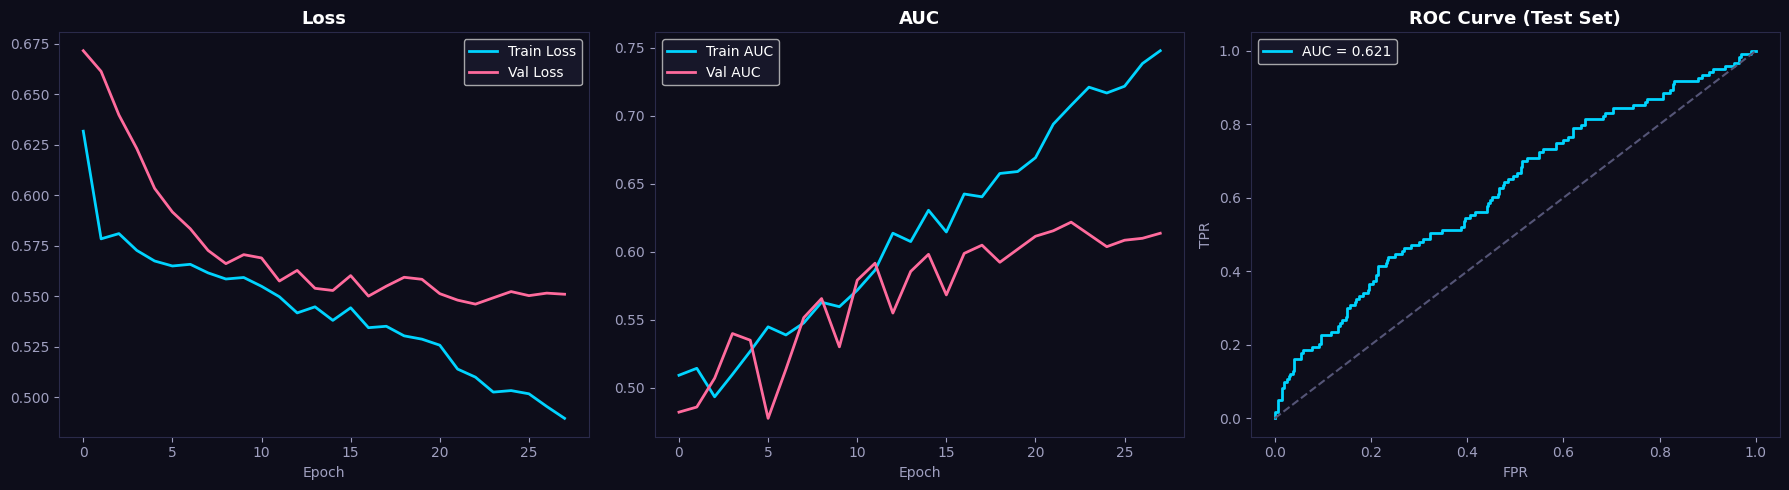

Test ROC-AUC: 0.6214


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor('#0d0d1a')
for ax in axes:
    ax.set_facecolor('#0d0d1a')
    ax.tick_params(colors='#a0a0c0')
    for spine in ax.spines.values():
        spine.set_edgecolor('#2a2a4a')

# ── Loss curve
axes[0].plot(history.history['loss'],     color='#00d4ff', linewidth=2, label='Train Loss')
axes[0].plot(history.history['val_loss'], color='#ff6b9d', linewidth=2, label='Val Loss')
axes[0].set_title('Loss', color='white', fontsize=13, fontweight='bold')
axes[0].legend(facecolor='#1a1a2e', labelcolor='white')
axes[0].set_xlabel('Epoch', color='#a0a0c0')

# ── AUC curve
axes[1].plot(history.history['auc'],     color='#00d4ff', linewidth=2, label='Train AUC')
axes[1].plot(history.history['val_auc'], color='#ff6b9d', linewidth=2, label='Val AUC')
axes[1].set_title('AUC', color='white', fontsize=13, fontweight='bold')
axes[1].legend(facecolor='#1a1a2e', labelcolor='white')
axes[1].set_xlabel('Epoch', color='#a0a0c0')

# ── ROC on test set
y_pred_proba = model.predict([X_seq_test, X_pos_test, X_base_test], verbose=0).flatten()
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
axes[2].plot(fpr, tpr, color='#00d4ff', linewidth=2, label=f'AUC = {roc_auc:.3f}')
axes[2].plot([0,1],[0,1], '--', color='#555577')
axes[2].set_title('ROC Curve (Test Set)', color='white', fontsize=13, fontweight='bold')
axes[2].legend(facecolor='#1a1a2e', labelcolor='white')
axes[2].set_xlabel('FPR', color='#a0a0c0')
axes[2].set_ylabel('TPR', color='#a0a0c0')

plt.tight_layout()
plt.savefig('helixmind_training_curves.png', dpi=150, bbox_inches='tight', facecolor='#0d0d1a')
plt.show()
print(f'Test ROC-AUC: {roc_auc:.4f}')

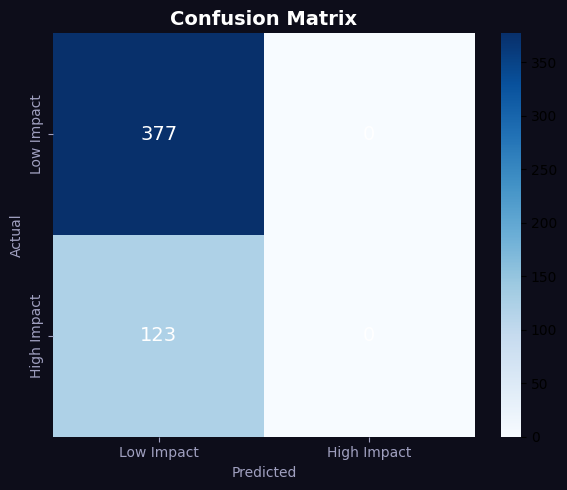


Classification Report:
              precision    recall  f1-score   support

  Low Impact       0.75      1.00      0.86       377
 High Impact       0.00      0.00      0.00       123

    accuracy                           0.75       500
   macro avg       0.38      0.50      0.43       500
weighted avg       0.57      0.75      0.65       500



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
# Confusion Matrix
y_pred = (y_pred_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 5))
fig.patch.set_facecolor('#0d0d1a')
ax.set_facecolor('#0d0d1a')

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Impact', 'High Impact'],
            yticklabels=['Low Impact', 'High Impact'],
            ax=ax, annot_kws={'size': 14, 'color': 'white'})
ax.set_title('Confusion Matrix', color='white', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted', color='#a0a0c0')
ax.set_ylabel('Actual', color='#a0a0c0')
ax.tick_params(colors='#a0a0c0')

plt.tight_layout()
plt.savefig('helixmind_confusion.png', dpi=150, bbox_inches='tight', facecolor='#0d0d1a')
plt.show()

print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Low Impact', 'High Impact']))

## Step 7 — Live Prediction Demo
###  HelixMind Mutation Assessor

In [10]:
def predict_mutation_impact(sequence, mutation_position, new_base, verbose=True):
    """
    HelixMind Mutation Assessor

    Args:
        sequence (str): DNA sequence of length 50 (A/T/C/G)
        mutation_position (int): 0-indexed position of mutation
        new_base (str): New base after mutation (A/T/C/G)

    Returns:
        dict: Prediction results
    """
    assert len(sequence) == SEQ_LEN, f'Sequence must be {SEQ_LEN} bases long'
    assert 0 <= mutation_position < SEQ_LEN, 'Mutation position out of range'
    assert new_base in BASES, 'new_base must be A, T, C, or G'
    assert sequence[mutation_position] != new_base, 'New base must differ from original'

    # Apply mutation
    mutated = list(sequence)
    original_base = mutated[mutation_position]
    mutated[mutation_position] = new_base
    mutated_seq = ''.join(mutated)

    # Encode
    x_seq  = one_hot_encode(mutated_seq)[np.newaxis]         # (1, 50, 4)
    x_pos  = np.array([[mutation_position / SEQ_LEN]])       # (1, 1)
    x_base = np.array([[BASE_TO_IDX[new_base] / 3.0]])       # (1, 1)

    # Predict
    prob = float(model.predict([x_seq, x_pos, x_base], verbose=0)[0][0])
    label = 'HIGH IMPACT ' if prob >= 0.5 else 'LOW IMPACT  '
    confidence = prob if prob >= 0.5 else 1 - prob

    result = {
        'original_sequence': sequence,
        'mutation': f'{original_base}{mutation_position}{new_base}',
        'impact_probability': prob,
        'prediction': label,
        'confidence': confidence
    }

    if verbose:
        print('━' * 52)
        print('   HelixMind Mutation Impact Assessment')
        print('━' * 52)
        print(f'  Sequence:     {sequence[:25]}...{sequence[-5:]}')
        print(f'  Mutation:     {original_base}→{new_base} at position {mutation_position}')
        print(f'  Impact Prob:  {prob:.4f}')
        print(f'  Prediction:   {label}')
        print(f'  Confidence:   {confidence:.1%}')
        print('━' * 52)

    return result


# ─────────────────────────────────────────────
# Demo predictions — length guaranteed by code
# ─────────────────────────────────────────────

# Test 1: Mutation INSIDE ATGCG motif (HIGH IMPACT expected)
motif_pos_1 = 20
motif_1 = 'ATGCG'
test_seq_1 = 'A' * motif_pos_1 + motif_1 + 'A' * (SEQ_LEN - motif_pos_1 - len(motif_1))
print(f'Test 1 length: {len(test_seq_1)}')  # will print 50
print('\n Test 1 — Mutation inside functional motif ATGCG')
result1 = predict_mutation_impact(test_seq_1, mutation_position=motif_pos_1, new_base='C')

# Test 2: Mutation OUTSIDE any motif (LOW IMPACT expected)
test_seq_2 = 'ATCG' * 12 + 'AT'  # 48 + 2 = 50
print(f'\nTest 2 length: {len(test_seq_2)}')
print('\n Test 2 — Mutation in random region')
result2 = predict_mutation_impact(test_seq_2, mutation_position=5, new_base='G')

# Test 3: Mutation INSIDE TTAGG motif (HIGH IMPACT expected)
motif_pos_3 = 20
motif_3 = 'TTAGG'
test_seq_3 = 'G' * motif_pos_3 + motif_3 + 'C' * (SEQ_LEN - motif_pos_3 - len(motif_3))
print(f'\nTest 3 length: {len(test_seq_3)}')
print('\n Test 3 — Mutation inside TTAGG motif')
result3 = predict_mutation_impact(test_seq_3, mutation_position=motif_pos_3, new_base='A')

Test 1 length: 50

 Test 1 — Mutation inside functional motif ATGCG
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   HelixMind Mutation Impact Assessment
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Sequence:     AAAAAAAAAAAAAAAAAAAAATGCG...AAAAA
  Mutation:     A→C at position 20
  Impact Prob:  0.4157
  Prediction:   LOW IMPACT  
  Confidence:   58.4%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Test 2 length: 50

 Test 2 — Mutation in random region
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   HelixMind Mutation Impact Assessment
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Sequence:     ATCGATCGATCGATCGATCGATCGA...TCGAT
  Mutation:     T→G at position 5
  Impact Prob:  0.4498
  Prediction:   LOW IMPACT  
  Confidence:   55.0%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Test 3 length: 50

 Test 3 — Mutation inside TTAGG motif
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   HelixMind Mutation Impact Assessment
━━━━━━━━━━

## Step 8 — Interactive Assessor
### Enter your own mutation below

In [11]:
# ─── CUSTOMIZE THESE ────────────────────────
MY_SEQUENCE  = 'ATGCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGA'  # 50 bases
MY_MUT_POS   = 2       # 0-indexed position
MY_NEW_BASE  = 'T'     # A, T, C, or G (must differ from original)
# ────────────────────────────────────────────

result = predict_mutation_impact(MY_SEQUENCE, MY_MUT_POS, MY_NEW_BASE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   HelixMind Mutation Impact Assessment
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Sequence:     ATGCGATCGATCGATCGATCGATCG...ATCGA
  Mutation:     G→T at position 2
  Impact Prob:  0.3757
  Prediction:   LOW IMPACT  
  Confidence:   62.4%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


## Step 9 — Save Model (HelixMind Module)

In [13]:
model.save('helixmind_mutation_core_v0.keras')
print(' Model saved as: helixmind_mutation_core_v0.keras')
print('\n HelixMind Prototype Learning Core v0.1 — Ready for Integration')
print('   Next steps:')
print('   → Plug in real ClinVar / UniProt mutation data')
print('   → Scale to full gene sequences with sliding windows')
print('   → Add resistance phenotype prediction head')
print('   → Wrap in Streamlit / FastAPI for HelixMind backend')

 Model saved as: helixmind_mutation_core_v0.keras

 HelixMind Prototype Learning Core v0.1 — Ready for Integration
   Next steps:
   → Plug in real ClinVar / UniProt mutation data
   → Scale to full gene sequences with sliding windows
   → Add resistance phenotype prediction head
   → Wrap in Streamlit / FastAPI for HelixMind backend
